Upload your train.csv file


Saving train.csv to train.csv
✅ Dataset loaded — shape: (891, 12)

📊 Logistic Regression
Precision: 0.844 | Recall: 0.836 | F1: 0.840 | AUC: 0.825
Confusion Matrix:
 [[52 17]
 [18 92]]

📊 Random Forest
Precision: 0.827 | Recall: 0.827 | F1: 0.827 | AUC: 0.827
Confusion Matrix:
 [[50 19]
 [19 91]]


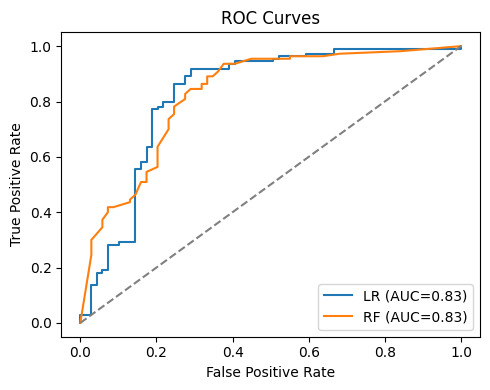


✅ Saved results as fast_model_results.csv


,Precision,Recall,F1,AUC
Logistic Regression,0.844037,0.836364,0.840183,0.825428
Random Forest,0.827273,0.827273,0.827273,0.826680


In [1]:
# ============================================
# FAST Customer Churn Prediction - Evaluation
# Author: Rabia Abdul Sattar
# Week 7 - Applied Data Science with AI
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import os, warnings
warnings.filterwarnings('ignore')

# === Load Dataset ===
csv_path = "/content/train.csv"
if not os.path.exists(csv_path):
    from google.colab import files
    print("Upload your train.csv file")
    uploaded = files.upload()
    csv_path = list(uploaded.keys())[0]

df = pd.read_csv(csv_path)
print("✅ Dataset loaded — shape:", df.shape)

# === Target Column Detection ===
if 'churn' in df.columns:
    target_col = 'churn'
elif 'Survived' in df.columns:
    df['churn'] = 1 - df['Survived']
    target_col = 'churn'
else:
    raise ValueError("No 'churn' or 'Survived' column found!")

# === Preprocessing (simplified) ===
# Fill missing values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c].fillna(df[c].median(), inplace=True)

# Encode only key categorical columns (to avoid slow get_dummies explosion)
cat_cols = [c for c in df.select_dtypes(include='object').columns if df[c].nunique() < 10]
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Select numeric features only
features = [c for c in df.columns if c not in ['PassengerId','Name','Ticket','Cabin','churn','Survived']]
X = df[features]
y = df[target_col]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features only
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# === Logistic Regression ===
lr = LogisticRegression(max_iter=300, solver='liblinear')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# === Random Forest (FAST) ===
rf = RandomForestClassifier(n_estimators=30, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# === Metrics ===
def evaluate(model_name, y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n📊 {model_name}")
    print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    print("Confusion Matrix:\n", cm)
    return [precision, recall, f1, auc]

results = {}
results['Logistic Regression'] = evaluate('Logistic Regression', y_test, y_pred_lr, y_prob_lr)
results['Random Forest'] = evaluate('Random Forest', y_test, y_pred_rf, y_prob_rf)

# === ROC Curve ===
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(5,4))
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={results["Logistic Regression"][3]:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={results["Random Forest"][3]:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.tight_layout()
plt.show()

# === Save Results ===
res_df = pd.DataFrame(results, index=['Precision','Recall','F1','AUC']).T
res_df.to_csv("fast_model_results.csv")
print("\n✅ Saved results as fast_model_results.csv")
display(res_df)
